# LIBRAIRIES IMPORTATION

In [1]:
import pandas as pd
import numpy as np
import datetime
import nbformat
import wordcloud

import seaborn as sns
pal = sns.color_palette()

import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly import tools
import plotly.io as pio
import io
pio.renderers.default = "vscode"

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import  StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from IPython.display import display
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings

 # FILES READING AND EDA

In [2]:
# Import dataset
print("Loading dataset...")
df = pd.read_csv("./assets/flights_usa_2019.csv")  # sep = ";"
pd.set_option('display.max_columns', None)
print("...Done.")
print()

Loading dataset...
...Done.



In [3]:
# # Formatting of flight numbers
# df['OP_CARRIER_FL_NUM'] = df['OP_UNIQUE_CARRIER'] + df['OP_CARRIER_FL_NUM'].astype(str)
# df.head(2)

In [4]:
#  Merge airports list into dataframe

airports = pd.read_csv('./assets/airports_list.csv')
airports.head()

,ORIGIN_AIRPORT_ID,DISPLAY_AIRPORT_NAME,ORIGIN_CITY_NAME,NAME
0,12992,Adams Field,"Little Rock, AR","NORTH LITTLE ROCK AIRPORT, AR US"
1,10257,Albany International,"Albany, NY","ALBANY INTERNATIONAL AIRPORT, NY US"
2,10140,Albuquerque International Sunport,"Albuquerque, NM","ALBUQUERQUE INTERNATIONAL AIRPORT, NM US"
3,10299,Anchorage International,"Anchorage, AK","ANCHORAGE TED STEVENS INTERNATIONAL AIRPORT, A..."
4,10397,Atlanta Municipal,"Atlanta, GA",ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...


In [5]:
df = pd.merge(df, airports[['ORIGIN_AIRPORT_ID','NAME']], left_on='ORIGIN_AIRPORT_ID', right_on='ORIGIN_AIRPORT_ID')
df.head(3)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32,NAME
0,1,6,7,9E,N8694A,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1643.0,0.0,0.0,1600-1659,1732,1720.0,0.0,1700-1759,0.0,NaN,47.0,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...
1,1,7,1,9E,N8970D,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1640.0,0.0,0.0,1600-1659,1732,1712.0,0.0,1700-1759,0.0,NaN,47.0,32.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...
2,1,8,2,9E,N820AY,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1640.0,0.0,0.0,1600-1659,1732,1719.0,0.0,1700-1759,0.0,NaN,47.0,39.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...


In [6]:
# Merge carriers list into dataframe
carriers = pd.read_csv('./assets/CARRIER_DECODE.csv')
carriers.drop_duplicates(subset=['OP_UNIQUE_CARRIER'], inplace=True)
df = pd.merge(df, carriers, on='OP_UNIQUE_CARRIER', how='left')

df.head(3)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Unnamed: 32,NAME,AIRLINE_ID,CARRIER_NAME
0,1,6,7,9E,N8694A,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1643.0,0.0,0.0,1600-1659,1732,1720.0,0.0,1700-1759,0.0,NaN,47.0,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,20363,Endeavor Air Inc.
1,1,7,1,9E,N8970D,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1640.0,0.0,0.0,1600-1659,1732,1712.0,0.0,1700-1759,0.0,NaN,47.0,32.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,20363,Endeavor Air Inc.
2,1,8,2,9E,N820AY,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1640.0,0.0,0.0,1600-1659,1732,1719.0,0.0,1700-1759,0.0,NaN,47.0,39.0,83.0,1,NaN,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,20363,Endeavor Air Inc.


In [7]:
df = df.drop([ 'Unnamed: 32', 'AIRLINE_ID'], axis=1)
df = df.rename(columns={'NAME': 'ORIGIN_AIRPORT_NAME'})

df.head(2)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,ORIGIN_AIRPORT_NAME,CARRIER_NAME
0,1,6,7,9E,N8694A,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1643.0,0.0,0.0,1600-1659,1732,1720.0,0.0,1700-1759,0.0,NaN,47.0,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.
1,1,7,1,9E,N8970D,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1640.0,0.0,0.0,1600-1659,1732,1712.0,0.0,1700-1759,0.0,NaN,47.0,32.0,83.0,1,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.


In [8]:
df.shape

(8467550, 34)

Select 10% of the lines randomly because the datset is too large (almost 10 million lines)

In [9]:
# Sélectionner 10% des lignes au hasard

# random_indices = np.random.choice(df.index, size=int(len(df)*0.1), replace=False)
# sampled_df = df.loc[random_indices]

# # Order by month
# sampled_df = sampled_df.sort_values('MONTH')

# export in csv
# sampled_df.to_csv("echantillon_df_10%.csv", index=False)

In [10]:
# Basic stats
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
data_desc = df.describe(include='all')
display(data_desc)
print()

print("Percentage of missing values: ")

pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/len(df)], axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})


Number of rows : 8467550

Display of dataset: 


,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,ORIGIN_AIRPORT_NAME,CARRIER_NAME
0,1,6,7,9E,N8694A,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1643.0,0.0,0.0,1600-1659,1732,1720.0,0.0,1700-1759,0.0,NaN,47.0,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.
1,1,7,1,9E,N8970D,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1640.0,0.0,0.0,1600-1659,1732,1712.0,0.0,1700-1759,0.0,NaN,47.0,32.0,83.0,1,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.
2,1,8,2,9E,N820AY,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1640.0,0.0,0.0,1600-1659,1732,1719.0,0.0,1700-1759,0.0,NaN,47.0,39.0,83.0,1,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.
3,1,9,3,9E,N840AY,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1640.0,0.0,0.0,1600-1659,1732,1717.0,0.0,1700-1759,0.0,NaN,47.0,37.0,83.0,1,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.
4,1,10,4,9E,N8969A,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1640.0,0.0,0.0,1600-1659,1732,1721.0,0.0,1700-1759,0.0,NaN,47.0,41.0,83.0,1,NaN,NaN,NaN,NaN,NaN,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.



Basics statistics: 


,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,ORIGIN_AIRPORT_NAME,CARRIER_NAME
count,8.467550e+06,8.467550e+06,8.467550e+06,8467550,8447243,8.467550e+06,8.467550e+06,8467550,8467550,8.467550e+06,8467550,8467550,8.467550e+06,8.319657e+06,8.319642e+06,8.319642e+06,8467550,8.467550e+06,8.310735e+06,8.291538e+06,8467550,8.467550e+06,153885,8.467458e+06,8.291538e+06,8.467550e+06,8.467550e+06,1.612989e+06,1.612989e+06,1.612989e+06,1.612989e+06,1.612989e+06,8467550,8467550
unique,NaN,NaN,NaN,17,5884,NaN,NaN,97,93,NaN,352,344,NaN,NaN,NaN,NaN,19,NaN,NaN,NaN,19,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86,17
top,NaN,NaN,NaN,WN,N485HA,NaN,NaN,ATL,"Chicago, IL",NaN,ATL,"Chicago, IL",NaN,NaN,NaN,NaN,0800-0859,NaN,NaN,NaN,2100-2159,NaN,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"CHICAGO OHARE INTERNATIONAL AIRPORT, IL US",Southwest Airlines Co.
freq,NaN,NaN,NaN,1686918,4124,NaN,NaN,498732,533869,NaN,378776,445778,NaN,NaN,NaN,NaN,583123,NaN,NaN,NaN,559544,NaN,78135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,533869,1686918
mean,6.534821e+00,1.575653e+01,3.917954e+00,NaN,NaN,2.439554e+03,1.266348e+04,NaN,NaN,1.269319e+04,NaN,NaN,1.345101e+03,1.348418e+03,1.430791e+01,1.917129e-01,NaN,1.497401e+03,1.470709e+03,1.430017e+01,NaN,1.817350e-02,NaN,1.458664e+02,1.405224e+02,8.352383e+02,3.812627e+00,2.091995e+01,3.645534e+00,1.669074e+01,9.154433e-02,2.713975e+01,NaN,NaN
std,3.128598e+00,8.774243e+00,1.995189e+00,NaN,NaN,1.758195e+03,1.517638e+03,NaN,NaN,1.522350e+03,NaN,NaN,4.948391e+02,5.100432e+02,4.715889e+01,3.936485e-01,NaN,5.265462e+02,5.499145e+02,4.689079e+01,NaN,1.335785e-01,NaN,7.386748e+01,7.412633e+01,6.048638e+02,2.377937e+00,6.325475e+01,3.049884e+01,3.999751e+01,3.316565e+00,5.244635e+01,NaN,NaN
min,1.000000e+00,1.000000e+00,1.000000e+00,NaN,NaN,1.000000e+00,1.014000e+04,NaN,NaN,1.013500e+04,NaN,NaN,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,NaN,1.000000e+00,1.000000e+00,0.000000e+00,NaN,0.000000e+00,NaN,1.000000e+00,2.500000e+01,6.600000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN
25%,4.000000e+00,8.000000e+00,2.000000e+00,NaN,NaN,9.690000e+02,1.129200e+04,NaN,NaN,1.129200e+04,NaN,NaN,9.200000e+02,9.220000e+02,0.000000e+00,0.000000e+00,NaN,1.106000e+03,1.051000e+03,0.000000e+00,NaN,0.000000e+00,NaN,9.100000e+01,8.600000e+01,3.950000e+02,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN
50%,7.000000e+00,1.600000e+01,4.000000e+00,NaN,NaN,2.045000e+03,1.288900e+04,NaN,NaN,1.288900e+04,NaN,NaN,1.331000e+03,1.336000e+03,0.000000e+00,0.000000e+00,NaN,1.525000e+03,1.510000e+03,0.000000e+00,NaN,0.000000e+00,NaN,1.280000e+02,1.220000e+02,6.720000e+02,3.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00,2.000000e+00,NaN,NaN
75%,9.000000e+00,2.300000e+01,6.000000e+00,NaN,NaN,3.678000e+03,1.393100e+04,NaN,NaN,1.405700e+04,NaN,NaN,1.749000e+03,1.756000e+03,7.000000e+00,0.000000e+00,NaN,1.931000e+03,1.926000e+03,8.000000e+00,NaN,0.000000e+00,NaN,1.750000e+02,1.720000e+02,1.068000e+03,5.000000e+00,1.800000e+01,0.000000e+00,2.000000e+01,0.000000e+00,3.300000e+01,NaN,NaN



Percentage of missing values: 


,Missing Records,Percentage (%)
MONTH,0,0.000000
DAY_OF_MONTH,0,0.000000
DAY_OF_WEEK,0,0.000000
OP_UNIQUE_CARRIER,0,0.000000
TAIL_NUM,20307,0.239821
OP_CARRIER_FL_NUM,0,0.000000
ORIGIN_AIRPORT_ID,0,0.000000
ORIGIN,0,0.000000
ORIGIN_CITY_NAME,0,0.000000
DEST_AIRPORT_ID,0,0.000000


In [11]:
# Remplacer les valeurs manquantes

print("Treatment of missing values... ")

# On récupère la vols qui ne sont pas annulés
df = df[df['CANCELLED'] == 0]

# Suppression des valeurs manquantes dans certaines features
df.dropna(subset=['DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DEL15', 'ARR_TIME', 'ARR_DELAY_NEW'], inplace=True)

# Imputation des valeurs manquantes par 0
cols_to_impute_zero = ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'CANCELLATION_CODE']
df[cols_to_impute_zero] = df[cols_to_impute_zero].fillna(0.0)

# traitement sur la feature WEATHER_DELAY:
df["WEATHER_DELAY"] = (df["WEATHER_DELAY"] > 0).astype(int)

# Imputation des valeurs manquantes de TAIL_NUM par le mode de la colonne
mode_tail_num = df['TAIL_NUM'].mode()[0]
df['TAIL_NUM'] = df['TAIL_NUM'].fillna(mode_tail_num)

# Imputation des valeurs manquantes de ARR_TIME et DEP_TIME par la médiane de ces colonnes
median_arr_time = df['ARR_TIME'].median()
median_dep_time = df['DEP_TIME'].median()
df['ARR_TIME'] = df['ARR_TIME'].fillna(median_arr_time)
df['DEP_TIME'] = df['DEP_TIME'].fillna(median_dep_time)

# Suppression des autres valeurs manquantes
df.dropna(inplace=True)

print('Done')
print()
print("Percentage of missing values of treatment: ")
pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/len(df)], axis=1).rename(columns={0:'Missing Records', 1:'Percentage (%)'})

Treatment of missing values... 
Done

Percentage of missing values of treatment: 


,Missing Records,Percentage (%)
MONTH,0,0.0
DAY_OF_MONTH,0,0.0
DAY_OF_WEEK,0,0.0
OP_UNIQUE_CARRIER,0,0.0
TAIL_NUM,0,0.0
OP_CARRIER_FL_NUM,0,0.0
ORIGIN_AIRPORT_ID,0,0.0
ORIGIN,0,0.0
ORIGIN_CITY_NAME,0,0.0
DEST_AIRPORT_ID,0,0.0


In [12]:
df.head(3)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,ORIGIN_AIRPORT_NAME,CARRIER_NAME
0,1,6,7,9E,N8694A,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1643.0,0.0,0.0,1600-1659,1732,1720.0,0.0,1700-1759,0.0,0.0,47.0,37.0,83.0,1,0.0,0,0.0,0.0,0.0,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.
1,1,7,1,9E,N8970D,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1640.0,0.0,0.0,1600-1659,1732,1712.0,0.0,1700-1759,0.0,0.0,47.0,32.0,83.0,1,0.0,0,0.0,0.0,0.0,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.
2,1,8,2,9E,N820AY,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1645,1640.0,0.0,0.0,1600-1659,1732,1719.0,0.0,1700-1759,0.0,0.0,47.0,39.0,83.0,1,0.0,0,0.0,0.0,0.0,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.


In [13]:
# plotting departure airports for better visualization

# colors = sns.color_palette("colorblind", len(years))
colors = pal

df_airport = df['ORIGIN_AIRPORT_NAME'].value_counts()[:10]
label = df_airport.index
size = df_airport.values

trace = go.Pie(labels=label, values=size, marker=dict(colors=colors),hole = .2)

data = [trace]
layout = go.Layout(
    title='Flights Origin Airport'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

D'après le graphique ci-dessus, nous savons que l'aéroport international de Chicago O'Hare est le plus fréquenté en 2019, suivi de l'aéroport international d'Atlanta Hartsfield.

In [14]:
# plotting departure city

df_c = df.ORIGIN_CITY_NAME.value_counts()[:10]

trace = go.Bar(
    x=df_c.index,
    y=df_c.values,
    marker=dict(
        color = df_c.values,
        colorscale='Jet',
        showscale=True
    )
)

data = [trace]
layout = go.Layout(
    title='Origin City Distribution', 
    yaxis = dict(title = 'Number of Flights')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

La barre de répartition ci-dessus montre que la plupart des vols partent de Chicago (plus 500 000 vols) et sont suivis par Atlanta.

In [15]:
df_airline = df.CARRIER_NAME.value_counts()[:10]

trace = go.Bar(
    x=df_airline.index,
    y=df_airline.values,
    marker=dict(
        color = df_airline.values,
        colorscale='Jet',
        showscale=True)
)

data = [trace]
layout = go.Layout(xaxis=dict(tickangle=15),
    title='Airline distribution', 
                   yaxis = dict(title = 'Number of Flights'))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

D'après le tableau ci-dessus, la compagnie aérienne la plus empruntée en 2019 est Southwest Airlines, suivi de American Airlines.

In [16]:
# Monthly flight traffic during the year

months = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May',6: 'Jun' , 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
df_m = df.MONTH.value_counts().to_frame().reset_index(names='index').sort_values(by='index')
df_m.columns = ['MONTH', 'FlightNum']
df_m.MONTHS = df_m.MONTH.map(months)

trace = go.Bar(
    x=df_m.MONTHS,
    y=df_m.FlightNum,
    marker=dict(
        color = df_m.FlightNum,
        colorscale='Reds',
        showscale=True)
)

data = [trace]
layout = go.Layout(
    title='Number of Flights (monthly)', 
    yaxis = dict(title = 'Number of Flights'
                                                )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

C:\Users\galus\AppData\Local\Temp\ipykernel_9136\848530057.py:6: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



La barre de distribution ci-dessus fournit des informations sur le nombre de vols par mois en 2019. Les plus élevés sont ceux de avril, juillet et aout. Par contre si nous comparons avec les autres mois, il n'y a pas de differnce de nombre de vols significative.

In [17]:
# Daily flight traffic during the year

days={1:'Monday', 2:'Tuesday', 3:'Wednesday', 4:'Thursday', 5:'Friday', 6:'Saturday', 7:'Sunday'}
df_d = df.DAY_OF_WEEK.value_counts().to_frame().reset_index(names='index').sort_values(by='index')
df_d.columns = ['DAY_OF_WEEK', 'FlightNum']
df_d.DAY_OF_WEEK = df_d.DAY_OF_WEEK.map(days)

trace1 = go.Bar(
    x=df_d.DAY_OF_WEEK,
    y=df_d.FlightNum,
    marker=dict(
        color = df_d.FlightNum,  
        showscale=True
    )
)

data = [trace1]
layout = go.Layout(
    title='# of Flights (Day of Week)', 
    yaxis = dict(title = 'Number of Flights'
  )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Selon le graphique ci-dessus, du lundi au vendredi, le nombre de vols est similaire et le plus bas est le samedi

In [18]:
# Percentage of delay per month

df['DEP_DELAY'] = np.where(df.DEP_DELAY_NEW>0,1,0)
df['ARR_DELAY'] = np.where(df.ARR_DELAY_NEW>0,1,0)
df_m = df.groupby('MONTH').DEP_DELAY_NEW.mean().round(2)

df_m.index = df_m.index.map(months)
trace1 = go.Bar(
    x=df_m.index,
    y=df_m.values,
    name = 'Departure_delay',
    marker = dict(
        color = 'green'
    )
)

df_m = df.groupby('MONTH').ARR_DELAY_NEW.mean().round(2)
df_m.index = df_m.index.map(months)

trace2 = go.Bar(
    x=df_m.index,
    y=df_m.values,
    name='Arrival_delay',
    marker=dict(
        color = 'red'
    )
)

data = [trace1,trace2]
layout = go.Layout(
    title='% Delay (Months)', 
    yaxis = dict(title = '%')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Selon le tableau ci-dessus, le retard d'arrivée est supérieur à celui du retard de départ. On l'observe en juin oû on a enregistré le plus grand nombre de retard.

In [19]:
# Percentage of delay per month

df_d = df.groupby('DAY_OF_WEEK').DEP_DELAY_NEW.mean().round(2)
df_d.index = df_d.index.map(days)

trace1 = go.Bar(
    x=df_d.index,
    y=df_d.values,
    name = 'Departure_delay',
    marker=dict(
        color = 'cyan'
    )
)

df_d = df.groupby('DAY_OF_WEEK').ARR_DELAY_NEW.mean().round(2)
df_d.index = df_d.index.map(days)

trace2 = go.Bar(
    x=df_d.index,
    y=df_d.values,
    name='Arrival_delay',
    marker=dict(
        color = 'indigo'
    )
)

data = [trace1,trace2]
layout = go.Layout(
    title='% Delay (Day of Week)', 
    yaxis = dict(title = '%')
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Selon le graphique ci-dessus, la plupart des retards se sont produits le jeudi, le vendredi et le dimanche. Cependant, à la différence du mois où le nombre de retards d'arrivée est supérieur au retard de départ, lorsque nous comparons par jour de la semaine, le nombre de retards de départ est supérieur à celui du retard d'arrivée.

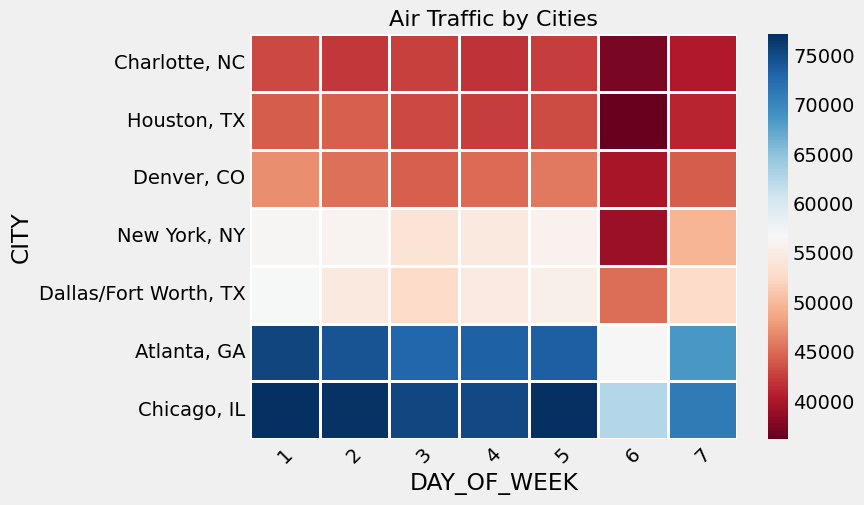

In [20]:
# Air traffic by city 

flight_volume = df.pivot_table(index="ORIGIN_CITY_NAME",columns="DAY_OF_WEEK",values="DAY_OF_MONTH",aggfunc=lambda x:x.count())
fv = flight_volume.sort_values(by=1, ascending=False)[:7]
fv = fv.iloc[::-1]

fig = plt.figure(figsize=(7, 5))
sns.heatmap(fv, cmap='RdBu',linecolor="w", linewidths=2)

plt.title('Air Traffic by Cities',size=16)
plt.ylabel('CITY')
plt.xticks(rotation=45)
plt.show()

D'après la carte ci-dessus, nous apprenons que samedi, de nombreuses personnes à Atlanta et à Chicago préfèrent ne pas quitter leur ville. Différent des autres villes où la plupart de leurs habitants choisissent de partir le samedi.

In [21]:
# Airlines comparison

df_a = df.groupby('CARRIER_NAME').DEP_DELAY_NEW.mean().to_frame().sort_values(by='DEP_DELAY_NEW', ascending=False).round(2)
trace1 = go.Bar(
    x=df_a.index,
    y=df_a.DEP_DELAY_NEW,
    name='Departure_delay',
    marker=dict(
        color = 'yellow'
    )
)

df_a = df.groupby('CARRIER_NAME').ARR_DELAY_NEW.mean().to_frame().sort_values(by='ARR_DELAY_NEW', ascending=False).round(2)
trace2 = go.Bar(
    x=df_a.index,
    y=df_a.ARR_DELAY_NEW,
    name='Arrival_delay',
    marker=dict(
        color = 'orange'
    )
)

data = [trace1, trace2]
layout = go.Layout(xaxis=dict(tickangle=15), title='Mean Arrival & Departure Delay by Airlines',
    yaxis = dict(title = 'minute'), 
                   barmode='stack')

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

In [22]:
df['DEP_ARR_DIFF'] = df['DEP_DELAY_NEW'] - df['ARR_DELAY_NEW']
df_dif = df.groupby('CARRIER_NAME').DEP_ARR_DIFF.mean().to_frame().sort_values(by='DEP_ARR_DIFF', ascending=False).round(2)

trace = go.Bar(
    x=df_dif.index,
    y=df_dif.DEP_ARR_DIFF,
    marker=dict(
        color = df_dif.DEP_ARR_DIFF,
        colorscale='Jet',
        showscale=True
    )
)

data = [trace]
layout = go.Layout(xaxis=dict(tickangle=15),
    title='Mean (Departure Delay - Arrival Delay) by Airlines', 
                   yaxis = dict(title = 'minute')
                  )

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

Nous pouvons voir qu'il y a plusieurs compagnies aériennes dont le nombre de retards à l'arrivée est supérieur à celui du retard au départ comme : American Eagle Airlines ou encore Midwest Airline.

In [23]:
# Correlation Matrix

import plotly.graph_objs as go
import numpy as np

# Création d'un tableau de données aléatoires pour illustrer l'exemple
correlation = df[['DAY_OF_WEEK','MONTH','ACTUAL_ELAPSED_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY_NEW']].fillna(0).corr()
cols = correlation.columns.values
corr  = correlation.values

# Création d'un Heatmap avec les données
trace = go.Heatmap(z=corr,
                   x=cols,
                   y=cols,
                   reversescale=True)

# Ajout des annotations de texte à l'intérieur du Heatmap
annotations = []
for i in range(corr.shape[0]):
    for j in range(corr.shape[1]):
        annotations.append(dict(x=cols[j], y=cols[i], text='{:.2f}'.format(corr[i, j]), font=dict(color='white'), showarrow=False))

# Configuration du layout
layout = go.Layout(dict(title="Correlation Matrix for variables",
                        autosize=False,
                        height=600,
                        width=800,
                        margin=dict(l=200),
                        yaxis=dict(tickfont=dict(size=8)),
                        xaxis=dict(tickfont=dict(size=8)),
                        annotations=annotations))

# Création de la figure avec le Heatmap et le layout
fig = go.Figure(data=[trace], layout=layout)

# Affichage de la figure
fig.show()


Selon la carte thermique, DISTANCE, ACTUAL_ELAPSED_TIME et CRS_ELAPSED_TIME ont une corrélation élevée et ARR_TIME a une corrélation élevée avec CRS_ARR_TIME.

# CLEANING

1. DATES AND TIMES

In [24]:
df['DATE'] = pd.to_datetime(df.DAY_OF_MONTH.map(str)+'-'+df.MONTH.map(str)+'-'+'2019', format='%d-%m-%Y')


In [25]:
# Définir une fonction pour formater les valeurs en heures
def format_hour():
    if time == '' or time == 'NaN' or time == None:
        return ''
    else:
        time = int(time)
        hour = str(time // 100).zfill(2)
        minute = str(time % 100).zfill(2)
        return "{}:{}:00".format(hour, minute)

# Définir une fonction pour convertir en l'heure en secondes 
def format_minutes(time='None'):
    if time == '' or time == 'NaN' or time == None:
        return ''
    else:
        time = int(time)
        minutes = (time//100)*60 + (time%100)
        return minutes


In [26]:
# Apply seconds on time

df['CRS_DEP_TIME'] = df['CRS_DEP_TIME'].apply(format_minutes)
df['DEP_TIME'] = df['DEP_TIME'].apply(format_minutes)
df['CRS_ARR_TIME'] = df['CRS_ARR_TIME'].apply(format_minutes)
df['ARR_TIME'] = df['ARR_TIME'].apply(format_minutes)

df.head(3)

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,CRS_DEP_TIME,DEP_TIME,DEP_DELAY_NEW,DEP_DEL15,DEP_TIME_BLK,CRS_ARR_TIME,ARR_TIME,ARR_DELAY_NEW,ARR_TIME_BLK,CANCELLED,CANCELLATION_CODE,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,ORIGIN_AIRPORT_NAME,CARRIER_NAME,DEP_DELAY,ARR_DELAY,DEP_ARR_DIFF,DATE
0,1,6,7,9E,N8694A,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1005,1003,0.0,0.0,1600-1659,1052,1040,0.0,1700-1759,0.0,0.0,47.0,37.0,83.0,1,0.0,0,0.0,0.0,0.0,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.,0,0,0.0,2019-01-06
1,1,7,1,9E,N8970D,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1005,1000,0.0,0.0,1600-1659,1052,1032,0.0,1700-1759,0.0,0.0,47.0,32.0,83.0,1,0.0,0,0.0,0.0,0.0,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.,0,0,0.0,2019-01-07
2,1,8,2,9E,N820AY,3280,10397,ATL,"Atlanta, GA",11150,CSG,"Columbus, GA",1005,1000,0.0,0.0,1600-1659,1052,1039,0.0,1700-1759,0.0,0.0,47.0,39.0,83.0,1,0.0,0,0.0,0.0,0.0,ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPO...,Endeavor Air Inc.,0,0,0.0,2019-01-08


# Airlines Stats

In [27]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on departure delay for each airline:
global_stats = df['DEP_DELAY_NEW'].groupby(df['CARRIER_NAME']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
CARRIER_NAME,,,,
Allegiant Air,0.0,1499.0,67707.0,14.425451
Hawaiian Airlines Inc.,0.0,1536.0,97761.0,5.028907
Atlantic Southeast Airlines,0.0,1751.0,125226.0,22.994043
Frontier Airlines Inc.,0.0,1022.0,155195.0,19.071239
Mesa Airlines Inc.,0.0,2036.0,226412.0,17.440555
Spirit Air Lines,0.0,1434.0,244970.0,15.124803
Endeavor Air Inc.,0.0,1407.0,258521.0,15.123255
Comair Inc.,0.0,1844.0,285539.0,15.045353
American Eagle Airlines Inc.,0.0,2672.0,293341.0,12.416260


# Relation between the origin airport and delays

Nous allons maintenant essayer de définir s'il existe une corrélation entre les retards enregistrés et l'aéroport d'origine.

In [28]:
print("Nb of airports: {}".format(len(df['ORIGIN'].unique())))

Nb of airports: 97


Geographical area covered by airlines

In [29]:
origin_nb = dict()
companies = df['CARRIER_NAME'].unique().tolist()

for carrier in companies:
    liste_origin_airport = df[df['CARRIER_NAME'] == carrier]['ORIGIN'].unique()
    origin_nb[carrier] = len(liste_origin_airport)

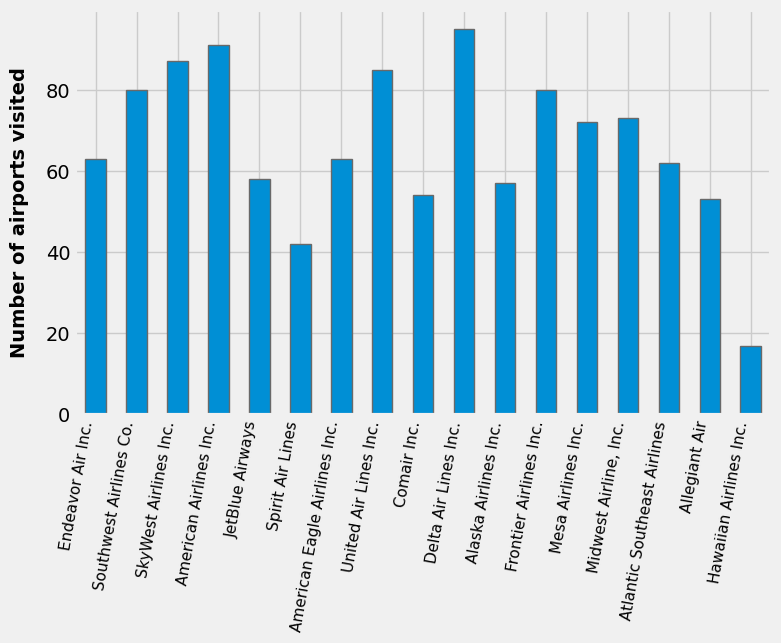

In [30]:
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns = {0:'count'}, inplace = True)
ax = test_df.plot(kind='bar', figsize = (8,5))
labels = [company for company in companies]
ax.set_xticklabels(labels)
plt.ylabel('Number of airports visited', fontsize=14, weight = 'bold', labelpad=12)
plt.setp(ax.get_xticklabels(), fontsize=11, ha = 'right', rotation = 80)
ax.legend().set_visible(False)
plt.show()

How the origin airport impact delays

Essayons de voir les variations des retards par rapport à l'aéroport d'origine et pour chaque compagnie aérienne. La première étape consiste donc à déterminer les retards moyens par aéroport.

In [31]:
# creons un dictionnaire de "DISPLAY_AIRPORT_NAME", pour facilement identifier la ville d'origine .
identify_airport = airports.set_index('DISPLAY_AIRPORT_NAME')['ORIGIN_CITY_NAME'].to_dict()

airport_mean_delays = pd.DataFrame(pd.Series(df['ORIGIN'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in companies:
    df1 = df[df['CARRIER_NAME'] == carrier]
    test = df1['DEP_DELAY_NEW'].groupby(df['ORIGIN']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 

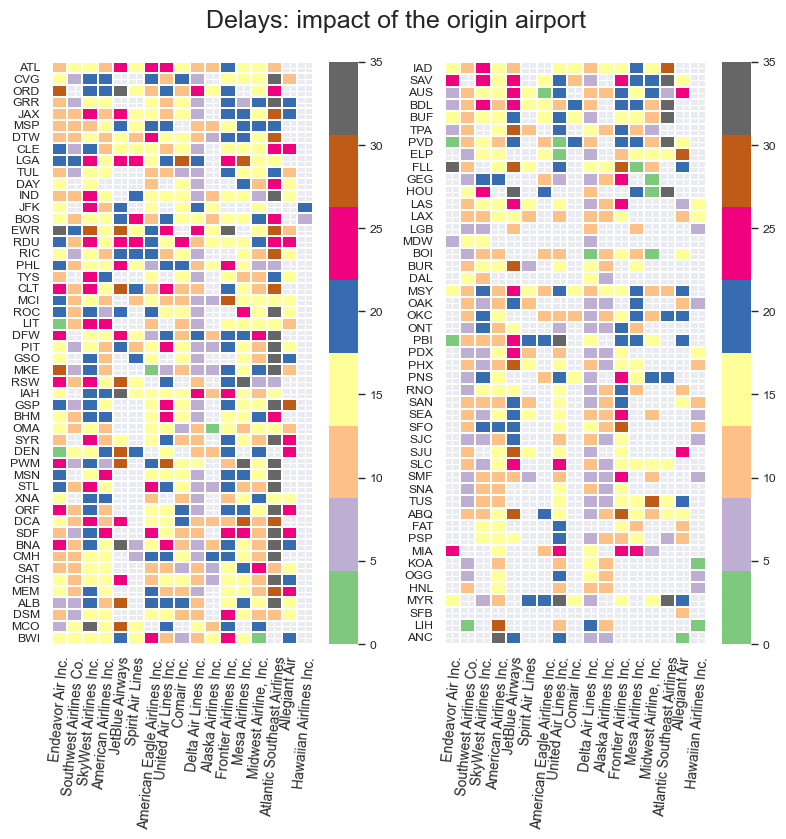

In [32]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(8,8))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:50,:]
subset = subset.rename(index = identify_airport)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85)
ax.yaxis.label.set_visible(False)

ax = fig.add_subplot(1,2,2)    
subset = airport_mean_delays.iloc[50:100,:]
subset = subset.rename(index = identify_airport)
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85)
ax.yaxis.label.set_visible(False)

plt.tight_layout()

Comme on peut le constater, la ville a une grande influence sur les retards

# MODELISATION
    Avec toutes les données qu'on a à disposition, nous avons la capacité de predire s'il y'aura du retard d'un vol à l'arrivée ou depart, et ceci en fonction des differents parmètres une ville spécifique d'arrivéé ou de départ, une compagnie spécifique, un aéroport spécifique d'arrivée ou départ, le jour ou encore le mois de départ etc...
    mais nous n'allons pas trop nous étendre sur ces différentes optiions sinon cela créera un schema trop long, c'est pour cela qui nous allons prédire un retard ou nous sur les départs uniquements sur l'ensemble du jeu.

In [33]:
# unique_carrier = input('Insérer le code carrier: ')

# carrier_df = sampled_df[sampled_df['OP_UNIQUE_CARRIER'] == str(unique_carrier).upper()]

In [34]:
print(list(df.columns))

['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM', 'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID', 'DEST', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY_NEW', 'DEP_DEL15', 'DEP_TIME_BLK', 'CRS_ARR_TIME', 'ARR_TIME', 'ARR_DELAY_NEW', 'ARR_TIME_BLK', 'CANCELLED', 'CANCELLATION_CODE', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DISTANCE', 'DISTANCE_GROUP', 'CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY', 'ORIGIN_AIRPORT_NAME', 'CARRIER_NAME', 'DEP_DELAY', 'ARR_DELAY', 'DEP_ARR_DIFF', 'DATE']


In [35]:
# We collect only the columns that will be used

df = df[['DAY_OF_MONTH','MONTH', 'OP_UNIQUE_CARRIER', 'OP_CARRIER_FL_NUM', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST', 'DEST_CITY_NAME', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'DEP_DELAY_NEW', 'WEATHER_DELAY', 'CRS_ELAPSED_TIME']]

In [36]:
# Vu le grand nombre de ligne , on va separer le dataset Sélectionner 5% des lignes au hasard

random_indices = np.random.choice(df.index, size=int(len(df)*0.05), replace=False)
sampled_df = df.loc[random_indices]

# Order by month
sampled_df = sampled_df.sort_values('MONTH')

In [37]:
# Creation d'un nouveau et ajout d'une colonne d'indicateur de retard qui sera notre variable cible
df_new = sampled_df.copy()
df_new["DELAYED"] = (df_new["DEP_DELAY_NEW"] > 0).astype(int)
df_new = df_new.drop(['DEP_DELAY_NEW'], axis=1)
df_new.head(3)

,DAY_OF_MONTH,MONTH,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,CRS_ARR_TIME,WEATHER_DELAY,CRS_ELAPSED_TIME,DELAYED
7710372,21,1,OO,3412,SJC,"San Jose, CA",SNA,"Santa Ana, CA",1145,1225,0,80.0,0
19386,27,1,F9,1515,ATL,"Atlanta, GA",LAX,"Los Angeles, CA",556,686,0,310.0,0
1056323,10,1,AA,233,MSP,"Minneapolis, MN",CLT,"Charlotte, NC",951,1165,0,154.0,1


    # PREDICTION DE VOL RETARDE OU PAS

In [38]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "DELAYED"

X = df_new.drop(target_variable, axis = 1)
Y = df_new[target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
7710372    0
19386      0
1056323    1
561942     1
5503653    0
Name: DELAYED, dtype: int32

X :
         DAY_OF_MONTH  MONTH OP_UNIQUE_CARRIER  OP_CARRIER_FL_NUM ORIGIN   
7710372            21      1                OO               3412    SJC  \
19386              27      1                F9               1515    ATL   
1056323            10      1                AA                233    MSP   
561942             14      1                AA                294    ORD   
5503653            13      1                NK               1118    TPA   

        ORIGIN_CITY_NAME DEST             DEST_CITY_NAME  CRS_DEP_TIME   
7710372     San Jose, CA  SNA              Santa Ana, CA          1145  \
19386        Atlanta, GA  LAX            Los Angeles, CA           556   
1056323  Minneapolis, MN  CLT              Charlotte, NC           951   
561942       Chicago, IL  LGA               New York, NY          1050   
5503653        Tampa, FL 

In [39]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []

for nom_colonne, dtype in X.dtypes.items():
    if ('float' in str(dtype)) or ('int' in str(dtype)):
        numeric_features.append(nom_colonne)
    else:
        categorical_features.append(nom_colonne)

print('numeric features detected : ', numeric_features)
print('categorical features détected : ', categorical_features)

numeric features detected :  ['DAY_OF_MONTH', 'MONTH', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'WEATHER_DELAY', 'CRS_ELAPSED_TIME']
categorical features détected :  ['OP_UNIQUE_CARRIER', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST', 'DEST_CITY_NAME']


In [40]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
# WARNING : don't forget stratify=Y for classification problems
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



PREPROCESSING

In [41]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # no missing values in categorical data, so we only need the OHE

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [42]:

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_train.head())
encoder = LabelEncoder()
Y_train = encoder.fit_transform(Y_train)
print("...Done")
print(Y_train[0:5])

# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head()) 
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()
# Label encoding
print("Encoding labels...")
print(Y_test[0:5])
Y_test = encoder.transform(Y_test)
print("...Done")
print(Y_test[0:5])

Performing preprocessings on train set...
         DAY_OF_MONTH  MONTH OP_UNIQUE_CARRIER  OP_CARRIER_FL_NUM ORIGIN   
547081             27      9                9E               5393    CVG  \
304361             27      7                DL               1317    ATL   
8269809            24     12                AA                457    MIA   
3893658            27     10                YX               3703    OMA   
3645840            26      4                YV               6374    IAH   

        ORIGIN_CITY_NAME DEST    DEST_CITY_NAME  CRS_DEP_TIME  CRS_ARR_TIME   
547081    Cincinnati, OH  MSP   Minneapolis, MN           419           490  \
304361       Atlanta, GA  JAX  Jacksonville, FL           651           719   
8269809        Miami, FL  PHX       Phoenix, AZ          1295            47   
3893658        Omaha, NE  EWR        Newark, NJ           425           660   
3645840      Houston, TX  PNS     Pensacola, FL          1290          1378   

         WEATHER_DELAY  CR

A. TRAIN MODEL ON XGBOOST

In [43]:
# Perform grid search
print("Grid search...")
xgboost = xgb.XGBClassifier(objective = 'binary:logistic', n_estimators=10, seed=123)

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6, 8], # exactly the same role as in scikit-learn
    'min_child_weight': [1, 2, 3, 4], # effect is more or less similar to min_samples_leaf and min_samples_split
    'n_estimators': [2, 4, 6, 8, 10], # exactly the same role as in scikit-learn
    'learning_rate': [0.1, 0.01, 0.001] # qui contrôle la vitesse à laquelle le modèle apprend à partir des données
}
print(params)
gridsearch_xbg = GridSearchCV(xgboost, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch_xbg.fit(X_train, Y_train)
print("...Done.")

# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch_xbg.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = gridsearch_xbg.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()

# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch_xbg.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = gridsearch_xbg.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()


Grid search...
{'max_depth': [2, 4, 6, 8], 'min_child_weight': [1, 2, 3, 4], 'n_estimators': [2, 4, 6, 8, 10], 'learning_rate': [0.1, 0.01, 0.001]}
...Done.
Predictions on training set...
...Done.
[0 0 0 ... 1 1 0]

Probabilities on training set...
...Done.
[[0.71828383 0.28171617]
 [0.6638205  0.33617952]
 [0.5350791  0.46492085]
 ...
 [0.47496367 0.52503633]
 [0.4277779  0.5722221 ]
 [0.6141634  0.38583657]]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 1]

Probabilities on test set...
...Done.
[[0.54009616 0.45990387]
 [0.5540155  0.44598448]
 [0.6898296  0.31017044]
 ...
 [0.50235045 0.49764952]
 [0.67043024 0.32956976]
 [0.40352064 0.59647936]]



In [44]:
print("Best hyperparameters : ", gridsearch_xbg.best_params_)
print("Best validation accuracy : ", gridsearch_xbg.best_score_)
print()
print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

print("Precision on training set : ", precision_score(Y_train, Y_train_pred))
print("Precision on test set : ", precision_score(Y_test, Y_test_pred))
print()

print("Recall on training set : ", recall_score(Y_train, Y_train_pred))
print("Recall on test set : ", recall_score(Y_test, Y_test_pred))
print()

Best hyperparameters :  {'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 10}
Best validation accuracy :  0.6789151566858238

accuracy on training set :  0.6820900922631611
accuracy on test set :  0.6806647691639732

f1-score on training set :  0.33915387026010657
f1-score on test set :  0.3364242393864969

Precision on training set :  0.6499315381104519
Precision on test set :  0.6440222606025715

Recall on training set :  0.2294417448970073
Recall on test set :  0.2276797829036635



B. TRAIN MODEL ON RANDOM FOREST

In [45]:
print("Grid search...")
rf = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6, 8],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [8],
    'n_estimators': [10, 20, 50, 100]
}
gridsearch_rf = GridSearchCV(rf, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch_rf.fit(X_train, Y_train)
print("...Done.")


# Entraîner le modèle sur les données d'entraînement
gridsearch_rf.fit(X_train, Y_train)

# Faire des prédictions sur les données de test
Y_pred = gridsearch_rf.predict(X_test)

print("Best hyperparameters : ", gridsearch_rf.best_params_)
print("Best validation accuracy : ", gridsearch_rf.best_score_)

# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch_rf.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = gridsearch_rf.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()


# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch_rf.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = gridsearch_rf.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 50}
Best validation accuracy :  0.6545287307759554
Predictions on training set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on training set...
...Done.
[[0.71246221 0.28753779]
 [0.6919853  0.3080147 ]
 [0.64822203 0.35177797]
 ...
 [0.57531615 0.42468385]
 [0.57643866 0.42356134]
 [0.62743527 0.37256473]]

Predictions on test set...
...Done.
[0 0 0 ... 0 0 0]

Probabilities on test set...
...Done.
[[0.59662529 0.40337471]
 [0.62883715 0.37116285]
 [0.6454026  0.3545974 ]
 ...
 [0.5837085  0.4162915 ]
 [0.69340192 0.30659808]
 [0.57450001 0.42549999]]



In [46]:
print("Best hyperparameters : ", gridsearch_rf.best_params_)
print("Best validation accuracy : ", gridsearch_rf.best_score_)
print()

print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

print("Precision on training set : ", precision_score(Y_train, Y_train_pred))
print("Precision on test set : ", precision_score(Y_test, Y_test_pred))
print()

print("Recall on training set : ", recall_score(Y_train, Y_train_pred))
print("Recall on test set : ", recall_score(Y_test, Y_test_pred))
print()

Best hyperparameters :  {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 50}
Best validation accuracy :  0.6545287307759554

accuracy on training set :  0.6527467888801785
accuracy on test set :  0.6528293694823677

f1-score on training set :  0.04572119846215033
f1-score on test set :  0.0463159289689902

Precision on training set :  0.9971087820744489
Precision on test set :  0.9928977272727273

Recall on training set :  0.02339702003883956
Recall on test set :  0.02371099050203528



C. TRAIN MODEL ON DECISION TREE

In [47]:
from sklearn.tree import DecisionTreeClassifier

# Perform grid search
print("Grid search...")
dtc = DecisionTreeClassifier()

# Grid of values to be tested
params = {
    'max_depth': [4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8]
}
gridsearch_dtc = GridSearchCV(dtc, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch_dtc.fit(X_train, Y_train)
print("...Done.")


# Entraîner le modèle sur les données d'entraînement
gridsearch_dtc.fit(X_train, Y_train)

# Faire des prédictions sur les données de test
Y_pred = gridsearch_dtc.predict(X_test)

print("Best hyperparameters : ", gridsearch_dtc.best_params_)
print("Best validation accuracy : ", gridsearch_dtc.best_score_)

# Predictions on training set
print("Predictions on training set...")
Y_train_pred = gridsearch_dtc.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on training set...")
Y_train_proba = gridsearch_dtc.predict_proba(X_train)
print("...Done.")
print(Y_train_proba)
print()


# Predictions on test set
print("Predictions on test set...")
Y_test_pred = gridsearch_dtc.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

# It's also possible to get the probabilities estimated by the model:
print("Probabilities on test set...")
Y_test_proba = gridsearch_dtc.predict_proba(X_test)
print("...Done.")
print(Y_test_proba)
print()

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best validation accuracy :  0.6772538164139043
Predictions on training set...
...Done.
[0 0 1 ... 1 1 0]

Probabilities on training set...
...Done.
[[0.83246711 0.16753289]
 [0.79109589 0.20890411]
 [0.46923077 0.53076923]
 ...
 [0.37566737 0.62433263]
 [0.37566737 0.62433263]
 [0.69383856 0.30616144]]

Predictions on test set...
...Done.
[0 0 0 ... 1 0 1]

Probabilities on test set...
...Done.
[[0.58725063 0.41274937]
 [0.59304348 0.40695652]
 [0.76846445 0.23153555]
 ...
 [0.45047733 0.54952267]
 [0.77572464 0.22427536]
 [0.30649639 0.69350361]]



In [48]:
print("Best hyperparameters : ", gridsearch_dtc.best_params_)
print("Best validation accuracy : ", gridsearch_dtc.best_score_)

print("accuracy on training set : ", accuracy_score(Y_train, Y_train_pred))
print("accuracy on test set : ", accuracy_score(Y_test, Y_test_pred))
print()

print("f1-score on training set : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set : ", f1_score(Y_test, Y_test_pred))
print()

print("Precision on training set : ", precision_score(Y_train, Y_train_pred))
print("Precision on test set : ", precision_score(Y_test, Y_test_pred))
print()

print("Recall on training set : ", recall_score(Y_train, Y_train_pred))
print("Recall on test set : ", recall_score(Y_test, Y_test_pred))
print()

Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best validation accuracy :  0.6772538164139043
accuracy on training set :  0.6825363323885907
accuracy on test set :  0.676781320854841

f1-score on training set :  0.37739486257628074
f1-score on test set :  0.36522974893415444

Precision on training set :  0.6233712957355785
Precision on test set :  0.6051805337519623

Recall on training set :  0.2706133767522324
Recall on test set :  0.26153324287652646



D'apres les differentes perfomances, XGBoost montre les meilleures perfomances, nous allons donc choisir ce model pour la suite de notre projet.

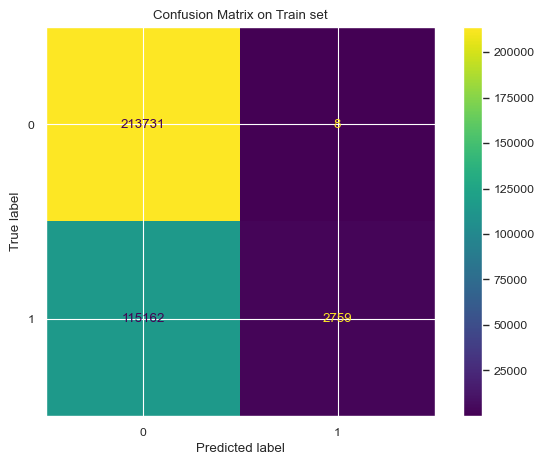

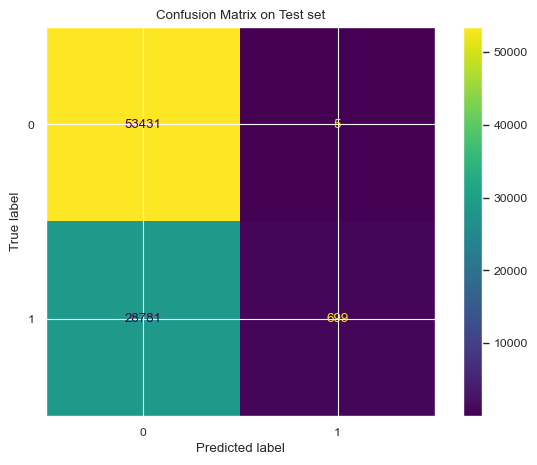

In [50]:
# Visualize confusion matrices
from sklearn.metrics import ConfusionMatrixDisplay


_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Train set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch_rf, X_train, Y_train, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_estimator(gridsearch_rf, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
plt.show()

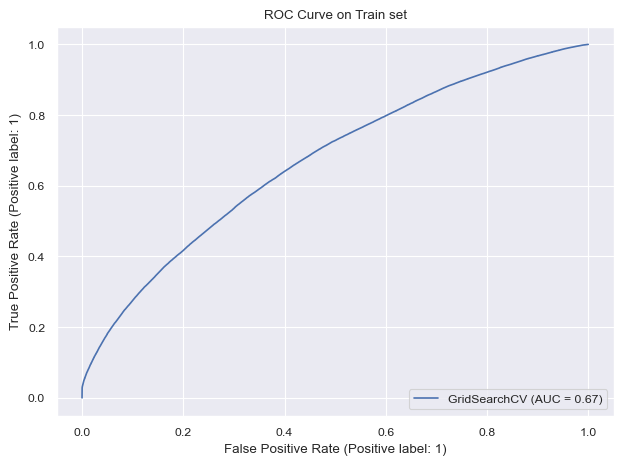

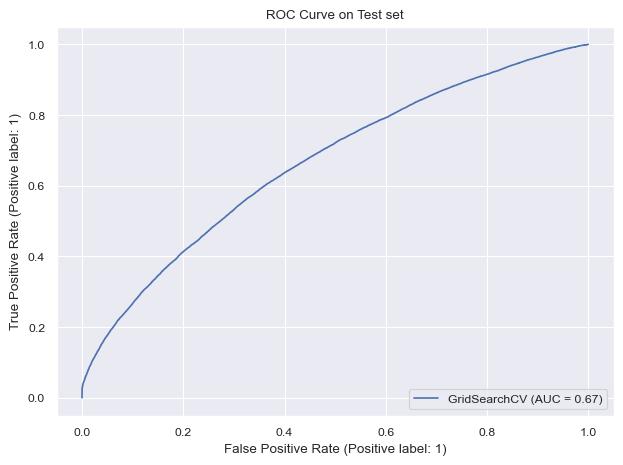

In [51]:
# Visualize ROC curves
from sklearn.metrics import RocCurveDisplay


_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Train set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch_rf, X_train, Y_train, ax=ax) # RocCurveDisplay from sklearn
plt.show()

_ , ax = plt.subplots() # Get subplot from matplotlib
ax.set(title="ROC Curve on Test set") # Set a title that we will add into ConfusionMatrixDisplay
RocCurveDisplay.from_estimator(gridsearch_rf, X_test, Y_test, ax=ax) # RocCurveDisplay from sklearn
plt.show()

Feature importance

In [52]:
column_names = []
for name, step, features_list in preprocessor.transformers_: # loop over steps of ColumnTransformer
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = step.get_feature_names_out() # get output columns names from OneHotEncoder
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['DAY_OF_MONTH', 'MONTH', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'WEATHER_DELAY', 'CRS_ELAPSED_TIME', 'OP_UNIQUE_CARRIER_9E', 'OP_UNIQUE_CARRIER_AA', 'OP_UNIQUE_CARRIER_AS', 'OP_UNIQUE_CARRIER_B6', 'OP_UNIQUE_CARRIER_DL', 'OP_UNIQUE_CARRIER_EV', 'OP_UNIQUE_CARRIER_F9', 'OP_UNIQUE_CARRIER_G4', 'OP_UNIQUE_CARRIER_HA', 'OP_UNIQUE_CARRIER_MQ', 'OP_UNIQUE_CARRIER_NK', 'OP_UNIQUE_CARRIER_OH', 'OP_UNIQUE_CARRIER_OO', 'OP_UNIQUE_CARRIER_UA', 'OP_UNIQUE_CARRIER_WN', 'OP_UNIQUE_CARRIER_YV', 'OP_UNIQUE_CARRIER_YX', 'ORIGIN_ABQ', 'ORIGIN_ALB', 'ORIGIN_ANC', 'ORIGIN_ATL', 'ORIGIN_AUS', 'ORIGIN_BDL', 'ORIGIN_BHM', 'ORIGIN_BNA', 'ORIGIN_BOI', 'ORIGIN_BOS', 'ORIGIN_BUF', 'ORIGIN_BUR', 'ORIGIN_BWI', 'ORIGIN_CHS', 'ORIGIN_CLE', 'ORIGIN_CLT', 'ORIGIN_CMH', 'ORIGIN_CVG', 'ORIGIN_DAL', 'ORIGIN_DAY', 'ORIGIN_DCA', 'ORIGIN_DEN', 'ORIGIN_DFW', 'ORIGIN_DSM', 'ORIGIN_DTW', 'ORIGIN_ELP', 'ORIGIN_EWR', 'ORIGIN_FAT', 'ORIGIN_FLL', 'ORIGIN_GEG', 'OR

In [53]:
# Create a pandas DataFrame
feature_importance = pd.DataFrame(index = column_names, data = gridsearch_rf.best_estimator_.feature_importances_, columns=["feature_importances"])
feature_importance = feature_importance.sort_values(by = 'feature_importances')

In [54]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

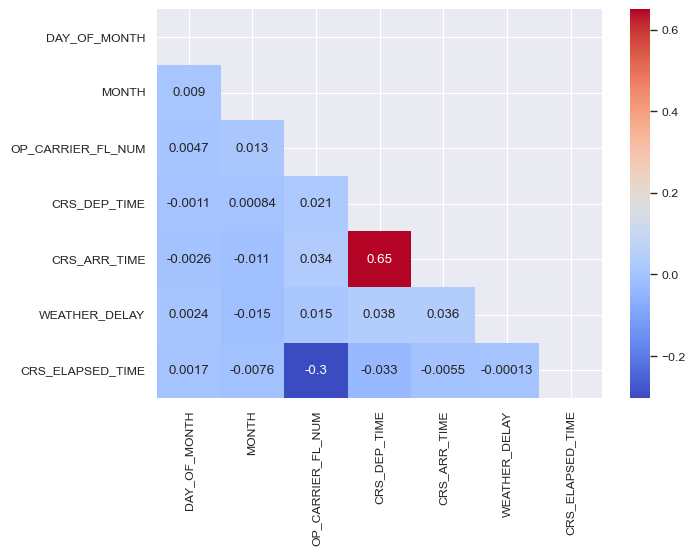

In [56]:
# Supprimer les fonctionnalités qui ont une corrélation faible avec la variable cible ou qui ont des valeurs manquantes élevées
corr_matrix = df_new[numeric_features].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_matrix = corr_matrix.mask(mask)
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)
plt.show()



    # PREDICTION DELAI MOYEN DE RETARD SI RETARD

In [57]:
sampled_df.head(5)

,DAY_OF_MONTH,MONTH,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_CITY_NAME,DEST,DEST_CITY_NAME,CRS_DEP_TIME,CRS_ARR_TIME,DEP_DELAY_NEW,WEATHER_DELAY,CRS_ELAPSED_TIME
7710372,21,1,OO,3412,SJC,"San Jose, CA",SNA,"Santa Ana, CA",1145,1225,0.0,0,80.0
19386,27,1,F9,1515,ATL,"Atlanta, GA",LAX,"Los Angeles, CA",556,686,0.0,0,310.0
1056323,10,1,AA,233,MSP,"Minneapolis, MN",CLT,"Charlotte, NC",951,1165,50.0,0,154.0
561942,14,1,AA,294,ORD,"Chicago, IL",LGA,"New York, NY",1050,1238,13.0,0,128.0
5503653,13,1,NK,1118,TPA,"Tampa, FL",GSO,"Greensboro/High Point, NC",1033,1135,0.0,0,102.0


In [58]:
# Separate target variable Y from features X
print("Separating labels from features...")
target_variable = "DEP_DELAY_NEW"

X = sampled_df.drop(target_variable, axis = 1)
Y = sampled_df[target_variable]

print("...Done.")
print()

print('Y : ')
print(Y.head())
print()
print('X :')
print(X.head())

Separating labels from features...
...Done.

Y : 
7710372     0.0
19386       0.0
1056323    50.0
561942     13.0
5503653     0.0
Name: DEP_DELAY_NEW, dtype: float64

X :
         DAY_OF_MONTH  MONTH OP_UNIQUE_CARRIER  OP_CARRIER_FL_NUM ORIGIN   
7710372            21      1                OO               3412    SJC  \
19386              27      1                F9               1515    ATL   
1056323            10      1                AA                233    MSP   
561942             14      1                AA                294    ORD   
5503653            13      1                NK               1118    TPA   

        ORIGIN_CITY_NAME DEST             DEST_CITY_NAME  CRS_DEP_TIME   
7710372     San Jose, CA  SNA              Santa Ana, CA          1145  \
19386        Atlanta, GA  LAX            Los Angeles, CA           556   
1056323  Minneapolis, MN  CLT              Charlotte, NC           951   
561942       Chicago, IL  LGA               New York, NY          1050   
55

In [59]:
# Automatically detect names of numeric/categorical columns
numeric_features = []
categorical_features = []

for nom_colonne, dtype in X.dtypes.items():
    if ('float' in str(dtype)) or ('int' in str(dtype)):
        numeric_features.append(nom_colonne)
    else:
        categorical_features.append(nom_colonne)

print('numeric features detected : ', numeric_features)
print('categorical features détected : ', categorical_features)

numeric features detected :  ['DAY_OF_MONTH', 'MONTH', 'OP_CARRIER_FL_NUM', 'CRS_DEP_TIME', 'CRS_ARR_TIME', 'WEATHER_DELAY', 'CRS_ELAPSED_TIME']
categorical features détected :  ['OP_UNIQUE_CARRIER', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST', 'DEST_CITY_NAME']


In [60]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



PREPROCESSING

In [61]:
# Create pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_transformer = OneHotEncoder(drop='first') # no missing values in categorical data, so we only need the OHE

# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [62]:
# Use ColumnTransformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train set
print("Performing preprocessings on train set...")
print(X_train.head())
X_train = preprocessor.fit_transform(X_train)
print('...Done.')
print(X_train[0:5]) # MUST use this syntax because X_train is a numpy array and not a pandas DataFrame anymore
print()


# Preprocessings on test set
print("Performing preprocessings on test set...")
print(X_test.head())
X_test = preprocessor.transform(X_test) # Don't fit again !! The test set is used for validating decisions
# we made based on the training set, therefore we can only apply transformations that were parametered using the training set.
# Otherwise this creates what is called a leak from the test set which will introduce a bias in all your results.
print('...Done.')
print(X_test[0:5,:]) # MUST use this syntax because X_test is a numpy array and not a pandas DataFrame anymore
print()

Performing preprocessings on train set...
         DAY_OF_MONTH  MONTH OP_UNIQUE_CARRIER  OP_CARRIER_FL_NUM ORIGIN   
3404769             5     11                OO               2986    DFW  \
1816379            22      8                WN                 51    IND   
1743594             9      1                YX               3663    TUL   
555175              1     11                OH               5666    CVG   
5631028            28      7                WN               1927    ELP   

              ORIGIN_CITY_NAME DEST    DEST_CITY_NAME  CRS_DEP_TIME   
3404769  Dallas/Fort Worth, TX  FLG     Flagstaff, AZ           700  \
1816379       Indianapolis, IN  MCI   Kansas City, MO           955   
1743594              Tulsa, OK  ORD       Chicago, IL           370   
555175          Cincinnati, OH  PHL  Philadelphia, PA           615   
5631028            El Paso, TX  SAN     San Diego, CA           990   

         CRS_ARR_TIME  WEATHER_DELAY  CRS_ELAPSED_TIME  
3404769          

TRAIN MODEL

In [63]:
# Train model
print("Train model...")
regressor = LinearRegression()
regressor.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


PERFOMANCE ASSESSMENT

In [64]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = regressor.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()


# Predictions on test set
print("Predictions on test set...")
Y_test_pred = regressor.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on training set...
...Done.
[ 9.45165242 12.49197191  4.55398315 ... 10.28887015 23.22076564
 13.95131713]

Predictions on test set...
...Done.
[17.68076011 96.83080257 14.76277185 ...  4.03268908  6.86209875
 12.18602463]



In [65]:
# Print scores
from sklearn.metrics import f1_score, precision_score, recall_score

print("R2 score on training set : ", r2_score(Y_train, Y_train_pred))
print("R2 score on test set : ", r2_score(Y_test, Y_test_pred))

print("MAE : ", mean_absolute_error(Y_test, Y_test_pred))
print()


print("MSE : ", mean_squared_error(Y_test, Y_test_pred))
print()

print("RMSE : ", np.sqrt(mean_squared_error(Y_test, Y_test_pred)))
print()


R2 score on training set :  0.05752906818261794
R2 score on test set :  0.059285358234258845
MAE :  19.58550515971099

MSE :  2035.4085169597163

RMSE :  45.115501958414654



In [66]:
# Importer les bibliothèques nécessaires
from sklearn.ensemble import RandomForestRegressor

# Créer l'objet de modèle Random Forest avec des hyperparamètres par défaut
rfc = RandomForestRegressor()

# Entraîner le modèle sur les données d'entraînement
rfc.fit(X_train, Y_train)

# Faire des prédictions sur les données de test
Y_pred = rfc.predict(X_test)

# Evaluer les performances du modèle
print("R2 score on test set : ", r2_score(Y_test, Y_pred))
print("MAE : ", mean_absolute_error(Y_test, Y_pred))
print("MSE : ", mean_squared_error(Y_test, Y_pred))
print("RMSE : ", np.sqrt(mean_squared_error(Y_test, Y_pred)))

Interpreting the model's coefficients

In [ ]:
regressor.coef_

array([-3.66654094e-02, -2.51006463e-01,  7.92215468e-01, -2.43085865e-01,
        4.71034251e+01,  1.13493507e-01,  4.48040164e+01, -4.55420732e+01,
        5.28730122e-01, -6.17741752e-01, -9.95957132e-01, -7.45454612e-01,
       -4.24392003e-01, -1.31013379e+00, -2.48031515e+00, -1.84704368e-01,
        1.39340864e+00, -7.19091469e-01, -5.35677486e-01, -1.44505390e+00,
       -1.16850393e+00, -3.77972593e-01, -5.56709695e-01, -3.65221809e-01])

In [ ]:
column_names = []
for name, pipeline, features_list in preprocessor.transformers_: # loop over pipelines
    if name == 'num': # if pipeline is for numeric variables
        features = features_list # just get the names of columns to which it has been applied
    else: # if pipeline is for categorical variables
        features = pipeline.get_feature_names_out()
    column_names.extend(features) # concatenate features names
        
print("Names of columns corresponding to each coefficient: ", column_names)

Names of columns corresponding to each coefficient:  ['MONTH', 'CRS_DEP_TIME', 'DEP_TIME', 'ARR_TIME', 'ARR_DELAY_NEW', 'CRS_ARR_TIME', 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'CARRIER_NAME_Allegiant Air', 'CARRIER_NAME_American Airlines Inc.', 'CARRIER_NAME_American Eagle Airlines Inc.', 'CARRIER_NAME_Atlantic Southeast Airlines', 'CARRIER_NAME_Comair Inc.', 'CARRIER_NAME_Delta Air Lines Inc.', 'CARRIER_NAME_Endeavor Air Inc.', 'CARRIER_NAME_Frontier Airlines Inc.', 'CARRIER_NAME_Hawaiian Airlines Inc.', 'CARRIER_NAME_JetBlue Airways', 'CARRIER_NAME_Mesa Airlines Inc.', 'CARRIER_NAME_Midwest Airline, Inc.', 'CARRIER_NAME_SkyWest Airlines Inc.', 'CARRIER_NAME_Southwest Airlines Co.', 'CARRIER_NAME_Spirit Air Lines', 'CARRIER_NAME_United Air Lines Inc.']


In [ ]:
# Create a pandas DataFrame
coefs = pd.DataFrame(index = column_names, data = regressor.coef_.transpose(), columns=["coefficients"])
coefs

,coefficients
MONTH,-0.036665
CRS_DEP_TIME,-0.251006
DEP_TIME,0.792215
ARR_TIME,-0.243086
ARR_DELAY_NEW,47.103425
CRS_ARR_TIME,0.113494
CRS_ELAPSED_TIME,44.804016
ACTUAL_ELAPSED_TIME,-45.542073
CARRIER_NAME_Allegiant Air,0.528730
CARRIER_NAME_American Airlines Inc.,-0.617742


In [ ]:
# Plot coefficients
fig = px.bar(feature_importance, orientation = 'h')
fig.update_layout(showlegend = False, 
                  margin = {'l': 120} # to avoid cropping of column names
                 )
fig.show()

Les résultats indiquent que notre modèle de régression logistique multiple est très performant. Le R2 score est proche de 1 sur les deux ensembles d'entraînement et de test, ce qui signifie que le modèle explique la grande majorité de la variance dans les données. La MAE (Mean Absolute Error) est relativement faible, ce qui indique que les prédictions du modèle sont en moyenne proches des valeurs réelles de la variable cible. De même, la RMSE (Root Mean Squared Error) est également faible, ce qui suggère que le modèle ne présente pas de grosses erreurs dans ses prédictions.

# DEPLOIEMENT DES MODELES SUR LE GRAND JEU DE DONNEES DF

1. Reg Logistic Pour predire s'il y'a retard ou pas.

In [ ]:
used_columns = ['MONTH', 'CARRIER_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'ARR_TIME',  'ARR_DELAY_NEW', 'CRS_ARR_TIME' , 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME']
used_columns_rlin = ['MONTH', 'CARRIER_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'ARR_TIME',  'ARR_DELAY_NEW', 'CRS_ARR_TIME' , 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DEP_DELAY_NEW']
used_columns_rlog = ['MONTH', 'CARRIER_NAME', 'CRS_DEP_TIME', 'DEP_TIME', 'ARR_TIME',  'ARR_DELAY_NEW', 'CRS_ARR_TIME' , 'CRS_ELAPSED_TIME', 'ACTUAL_ELAPSED_TIME', 'DELAYED']

In [ ]:
# Creation d'un nouveau df et ajout d'une colonne d'indicateur de retard qui sera notre variable cible sur le grand dataset
df["DELAYED"] = (df["DEP_DELAY_NEW"] > 0).astype(int)
rlog_df = df.copy()
rlog_df = rlog_df[used_columns_rlog]
rlog_df.dropna(inplace=True)
rlog_df.head(2)

,MONTH,CARRIER_NAME,CRS_DEP_TIME,DEP_TIME,ARR_TIME,ARR_DELAY_NEW,CRS_ARR_TIME,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DELAYED
0,1,Endeavor Air Inc.,1000,955.0,1110.0,1.0,1109,129.0,135.0,0
1,1,Endeavor Air Inc.,1722,1712.0,1809.0,0.0,1830,128.0,117.0,0


Preprocessing

In [ ]:
# Séparer les données en entrées X et cible Y
print("Separating labels from features...")

target_variable = "DELAYED"
X = rlog_df[used_columns]
Y = rlog_df[target_variable]

# Créer une instance de la classe OneHotEncoder pour encoder CARRIER_NAME

ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X[['CARRIER_NAME']])
carrier_encoded = ohe.transform(X[['CARRIER_NAME']]).toarray()
X = np.concatenate((X.drop('CARRIER_NAME', axis=1), carrier_encoded), axis=1)

print('Done...')

Separating labels from features...
Done...


In [ ]:
print()
(X[0:5,:])
print()
print(Y.head(5))



0    0
1    0
2    0
3    1
4    0
Name: DELAYED, dtype: int32


Train model

In [ ]:
# Entraîner votre modèle sur l'ensemble des données
print('Training model...')
classifier.fit(X, Y)
print('Done...')


Training model...
Done...


c:\Users\galus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [ ]:
# Prédire les valeurs de la cible pour l'ensemble des données
print('Predicting target...')
Y_pred = classifier.predict(X)
print('Done...')
print()
print(Y_pred[0:5])

Predicting target...
Done...

[0 0 1 1 0]


In [ ]:
# Print scores
from sklearn.metrics import f1_score, precision_score, recall_score


print("accuracy : ", accuracy_score(Y, Y_pred))
print()

print("f1-score: ", f1_score(Y, Y_pred))
print()

print("Precision: ", precision_score(Y, Y_pred))
print()

print("Recall: ", recall_score(Y, Y_pred))
print()

accuracy on training set :  0.812712568097983

f1-score on training set :  0.6933672868672394

Precision on training set :  0.8476351101888723

Recall on training set :  0.5866061840399925



Nous constatons qu'apres l'application du model sur le grand dataset, les metriques sont presque similaires, ce qui veut ce model s'est bien généralisé sur l'ensemble ded données.

2. Reg Lineaie multiple pour predire le temps de retard en cas de retard.

In [ ]:
# Creation d'un nouveau df et ajout d'une colonne d'indicateur de retard qui sera notre variable cible sur le grand dataset
rlin_df = df.copy()
rlin_df = rlin_df[used_columns_rlin]
rlin_df.dropna(inplace=True)
rlin_df.head(2)

,MONTH,CARRIER_NAME,CRS_DEP_TIME,DEP_TIME,ARR_TIME,ARR_DELAY_NEW,CRS_ARR_TIME,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DEP_DELAY_NEW
0,1,Endeavor Air Inc.,1000,955.0,1110.0,1.0,1109,129.0,135.0,0.0
1,1,Endeavor Air Inc.,1722,1712.0,1809.0,0.0,1830,128.0,117.0,0.0


In [ ]:
# Séparer les données en entrées X et cible Y
print("Separating labels from features...")

target_variable = "DEP_DELAY_NEW"
X = rlin_df[used_columns]
Y = rlin_df[target_variable]

# Créer une instance de la classe OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X[['CARRIER_NAME']])
carrier_encoded = ohe.transform(X[['CARRIER_NAME']]).toarray()
X = np.concatenate((X.drop('CARRIER_NAME', axis=1), carrier_encoded), axis=1)

print('Done...')

Separating labels from features...
Done...


In [ ]:
print()
(X[0:5,:])
print()
print(Y.head(5))



0      0.0
1      0.0
2      0.0
3    112.0
4      0.0
Name: DEP_DELAY_NEW, dtype: float64


In [ ]:
# Entraîner votre modèle sur l'ensemble des données
print('Training model...')
regressor.fit(X, Y)
print('Done...')

Training model...
Done...


In [ ]:
# Prédire les valeurs de la cible pour l'ensemble des données
print('Predicting target...')
Y_pred = regressor.predict(X)
print('Done...')
print()
print(Y_pred[0:5])

Predicting target...
Done...

[ -8.22822652   1.73612816  10.23926861 100.70319583   5.72685381]


In [ ]:
# Print scores

r2 = r2_score(Y, Y_pred)
mae = mean_absolute_error(Y, Y_pred)
mse = mean_squared_error(Y_test, Y_test_pred)
rmse = np.sqrt(mse)

print("R2 score: ", r2)
print()
print("MAE : ", mae)
print()

print("MSE : ", mse)
print()

print("RMSE : ", rmse)


R2 score:  0.9832617283916705

MAE :  4.607614614649519

MSE :  36.27588576200044

RMSE :  6.022946601290804


Nous constatons qu'apres l'application du model de regression pour predire le temps de retard sur le grand dataset, les metriques sont egalement presque similaires que sur le petit jeu de données, ce qui veut que ce model s'est également bien généralisé sur l'ensemble de données.

# ENREGISTREMENT DE NOS MODELES

In [ ]:
import pickle

# Enregistrer le modèle avec Pickle

print('Saving model...')
with open('./ml_models/classifier.pkl', 'wb') as f:
    pickle.dump(classifier, f)
print('Model saved!...')


Saving model...
Model saved!...


In [ ]:
print('Saving model...')
with open('./ml_models/regressor.pkl', 'wb') as f:
    pickle.dump(regressor, f)
print('Model saved!...')

Saving model...
Model saved!...


In [ ]:
['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK',
 : 		Jour de la semaine
OP_UNIQUE_CARRIER : Code transporteur, correspond à OP_UNIQUE_CARRIER dans d'autres fichiers
TAIL_NUM : Numéro de queue unique, correspond à TAIL_NUM dans d'autres fichiers
OP_CARRIER_FL_NUM : Numéro de vol
ORIGIN_AIRPORT_ID : ID de l'aéroport, correspond à ORIGIN_AIRPORT_ID dans d'autres fichiers
ORIGIN : Abréviation de l'aéroport d'origine
ORIGIN_CITY_NAME : 	Nom de la ville d'origine
DEST_AIRPORT_ID : ID de l'aéroport de destination, correspond à l'ID de l'aéroport dans d'autres fichiers
DEST : Abréviation de l'aéroport de destination
DEST_CITY_NAME : 	Nom de la ville de destination
CRS_DEP_TIME : 		Heure de départ prévue
DEP_TIME : 		Heure de départ réelle
DEP_DELAY_NEW : Retard de départ en minutes
DEP_DEL15 : TARGET VARIABLE Binaire si retard de plus de 15 min, 1 est oui
DEP_TIME_BLK : Blocage de l'heure de départ
CRS_ARR_TIME :		Heure d'arrivée prévue
ARR_TIME :		Heure d'arrivée réelle
ARR_DELAY_NEW : retard à l'arrivée en minutes
ARR_TIME_BLK : Blocage de l'heure d'arrivée
CANCELLED :		Indicateur si le vol a été annulé
CANCELLATION_CODE :	Code d'annulation
CRS_ELAPSED_TIME :	Temps écoulé prévu pour le vol
ACTUAL_ELAPSED_TIME :	Temps écoulé réel du vol
DISTANCE : Distance du vol en miles
DISTANCE_GROUP :		Groupe de distance du vol
CARRIER_DELAY : Indicateur de retard du transporteur
WEATHER_DELAY : Indicateur de retard dû aux conditions météorologiques
NAS_DELAY : Indicateur pour un retard NAS
SECURITY_DELAY : Indicateur d'un retard lié à la sécurité
LATE_AIRCRAFT_DELAY : In